# Connectivity Classifier

Steps:
1. Load the data
2. Fit a SVM + HPO
3. Permutation testing
4. Permutation Importance
5. SHAP

## Inputs

Connectivity matrices

## Outputs

- Classification output: Participant's label, either AVGP or NVGP.
- Results: `models/1_connectivity_classifier_results.nc`


## Requirements

To run this notebook, you need to have a few packages installed:

```bash
mamba create -n acnets python=3.9 jupyterlab ipykernel \
    matplotlib xarray netcdf4 shap nilearn=0.9.1
    # -c rapidsai -c nvidia -y \
    # rapids=22.04 cudatoolkit=11.5 \


mamba activate acnets

# pip install statannotations -U

# [Optional] Bayesian HBO
# pip install "ray[tune]" tune-sklearn scikit-optimize
```


## Analysis

In [1]:
# 0. SETUP

%reload_ext autoreload
%autoreload 3

import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as st
import xarray as xr
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score, learning_curve,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
# 0.1. PARAMETERS

CV = StratifiedShuffleSplit(n_splits=3, test_size=8)
N_PERMUTATIONS = 2

OUTPUT_PATH = Path('models/1_connectivity_classifier_results.nc')

In [3]:
# 1. DATA

subjects = ConnectivityPipeline().transform('all').coords['subject'].values
groups = [s[:4] for s in subjects]  # AVGP or NVGP

X = subjects.reshape(-1, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(groups)

In [4]:
# 2. PIPELINE

pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline()),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    ('select', SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=10000))),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=10000))
])

# DEBUG
# pipe.fit(X, y).score(X, y)

In [5]:
# 2.1. VERIFY THE MODEL
pipe.set_params(connectivity__atlas='dosenbach2010', connectivity__kind='partial correlation')

scores = cross_val_score(pipe, X, y,
                         cv=CV,
                         scoring='accuracy',
                         n_jobs=-1)
bootstrap_ci = st.bootstrap(scores.reshape(1,-1), np.mean)
scores.mean(), scores.std(), bootstrap_ci

(0.75,
 0.10206207261596575,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.625, high=0.8333333333333334), standard_error=0.0589694664740474))

In [ ]:
# 3. HPO: GRID SEARCH

param_grid = {
    'connectivity__atlas': ['gordon2014_2mm', 'dosenbach2010', 'difumo_64_2mm'],
    # 'connectivity__atlas': ['seitzman2018'],
    'connectivity__kind': ['partial correlation', 'tangent', 'correlation', 'covariance', 'precision'],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=CV,
    verbose=1,
    scoring='accuracy')

grid.fit(X, y)

print('best estimator:', grid.best_estimator_)


In [7]:
# 3.1. STORE GRID SEARCH RESULTS

#STORE pd.DataFrame(grid.cv_results_).set_index('params')
#STORE grid.scoring, grid.cv.test_size,  grid.cv.n_splits, n_subjects
grid_results = pd.DataFrame(grid.cv_results_)

grid_results['grid_model_name'] = grid_results['params'].apply(lambda x: ' '.join(x.values()))
grid_results.set_index('grid_model_name', inplace=True)
grid_results.drop(columns=['params'], inplace=True)

ds_grid = grid_results.to_xarray()
ds_grid['scoring'] = grid.scoring
ds_grid['cv_test_size'] = CV.test_size
ds_grid['cv_n_splits'] = CV.n_splits
ds_grid['n_subjects'] = len(X)

In [8]:
# 4. PERMUTATION TEST (SHUFFLE Y)


n_top_models = 3
perm_scores_agg = []
cv_scores_agg = []
pvalues = []
model_names = []

# sort by rank and take top n_top_models
top_models = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')[:n_top_models].loc[:,'params'].to_list()

for p in tqdm(top_models):
    model_name = ' '.join(p.values())
    
    pipe.set_params(**p)

    # break if it's a low score

    _, perm_scores, pvalue = permutation_test_score(pipe, X, y,
                                                    scoring='accuracy',
                                                    n_permutations=N_PERMUTATIONS,
                                                    cv=4,
                                                    n_jobs=-1, verbose=0)

    cv_scores = cross_val_score(pipe, X, y,
                                cv=CV,
                                scoring='accuracy', n_jobs=-1)

    perm_scores_agg.append(perm_scores)
    cv_scores_agg.append(cv_scores)
    pvalues.append(pvalue)
    model_names.append(model_name)

ds_perm = xr.Dataset({'perm_scores': (('model_name', 'permutation_dim'), perm_scores_agg),
                 'cv_scores': (('model_name', 'cv_dim'), cv_scores_agg),
                 'pvalue': (('model_name'), pvalues)},
                 coords={'model_name': model_names})

100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


In [9]:
# 5. FEATURE IMPORTANCE (SHUFFLE X)

importances_agg = []

for p in top_models:
    model_name = ' '.join(p.values())

    pipe.set_params(**p)

    X_conn = pipe[:2].transform(X)
    feature_names = pipe[:2].get_feature_names_out()

    importances = []

    for train, test in tqdm(CV.split(X,y), total=CV.get_n_splits(X,y)):
        pipe.fit(X[train], y[train])

        results = permutation_importance(pipe[2:], X_conn[test], y[test],
                                        scoring=grid.scoring,
                                        n_jobs=1)
        importances.append(results.importances.T)

    feature_dim_name = f'{model_name.split(" ")[0]}_feature'

    importances_ds = xr.Dataset({
        f'{model_name} importances': (('permutation_importance_num', feature_dim_name), np.vstack(importances))},
        coords={feature_dim_name: feature_names}
    )

    importances_agg.append(importances_ds)
    
    # sort by mean importance
    # importances = pd.DataFrame(np.vstack(importances), columns=feature_names)
    # sorted_columns = importances.mean(axis=0).sort_values(ascending=False).index
    # importances = importances[sorted_columns]

ds_imp = xr.merge(importances_agg)

100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


In [50]:
# 6. SHAP

import shap
from tqdm.auto import tqdm

shap_agg = []

for p in top_models:
  model_name = ' '.join(p.values())

  shap_values_cv = []
  test_indices = []
  y_test_cv = []
  y_pred_cv = []

  pipe.set_params(**p)

  feature_names = pipe[:2].get_feature_names_out()

  n_splits = CV.get_n_splits(X, y)

  X_conn = pipe[:2].fit_transform(X, y)

  for train, test in tqdm(CV.split(X, y), total=n_splits):

      shap_model = pipe[2:].fit(X_conn[train], y[train])

      y_pred = shap_model.predict(X_conn[test])

      test_indices.extend(test)
      y_test_cv.append(y[test])
      y_pred_cv.append(y_pred)

      explainer = shap.Explainer(
          shap_model.predict, X_conn[train],
          feature_names=feature_names,
          # approximate=True,
          # model_output='raw',
          # feature_perturbation='interventional',
      )

      shap_values = explainer(X_conn[test])#, check_additivity=True)

      shap_values_cv.append(shap_values)

  # merge CV SHAPs

  # X = subjects.reshape(-1, 1)
  # X_test = pd.DataFrame(X[np.hstack(test_indices)], columns=['subject'])
  y_test = np.hstack(y_test_cv)
  y_pred = np.hstack(y_pred_cv)

  # merge CV SHAPs
  shap_values = shap.Explanation(
    values = np.vstack([sh.values for sh in shap_values_cv]),
    base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
    data = np.vstack([sh.data for sh in shap_values_cv]),
    feature_names=feature_names,
    compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
    output_names=y_encoder.classes_,
    output_indexes=y_pred,
  )

  feature_dim_name = f'{model_name.split(" ")[0]}_feature'

  shap_ds = xr.Dataset({
    f'{model_name} shap': (('shap_dim', feature_dim_name), shap_values.values),
    f'{model_name} shap data': (('shap_dim', feature_dim_name), shap_values.data),
    f'{model_name} shap y_test': (('shap_dim'), y_encoder.inverse_transform(y_test)),
    f'{model_name} shap y_pred': (('shap_dim'), y_encoder.inverse_transform(y_pred)),
    },
    coords={feature_dim_name: feature_names}
  )

  shap_agg.append(shap_ds)

  # STORE y_pred, y_test, shap_values

ds_shap = xr.merge(shap_agg)

100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


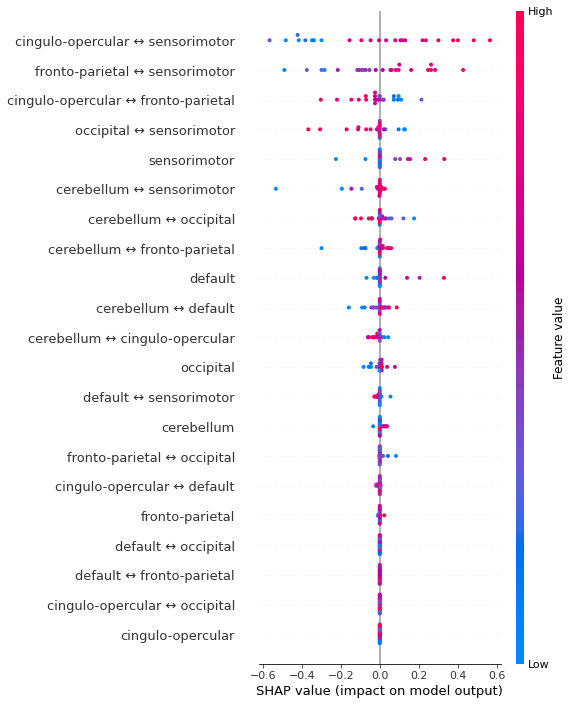

In [51]:
shap.summary_plot(shap_values,
                  feature_names=feature_names,
                  max_display=21)

In [11]:
# 7. LEARNING CURVE ANALYSIS

train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y,
                                                        cv=CV,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        shuffle=True,
                                                        train_sizes=np.array([16, 18, 20, 22, 24]))


learning_curve_results = pd.DataFrame({
    'learning_curve_train_size': train_sizes,
    'learning_curve_mean_train_score': train_scores.mean(axis=1),
    'learning_curve_mean_test_score': test_scores.mean(axis=1)
})

learning_curve_results.index.name  = 'learning_curve_num'

ds_learning_curve = learning_curve_results.to_xarray()

In [54]:
# 8. STORE RESULTS

results = xr.merge([
    {'X': xr.DataArray(X.flatten(), dims=['subject'])},
    {'y': xr.DataArray(y_encoder.inverse_transform(y), dims='subject')},
    {'y_classes': y_encoder.classes_},
    ds_grid, ds_learning_curve, ds_imp, ds_perm, ds_shap])

with open(OUTPUT_PATH, 'wb') as f:
    results.to_netcdf(f, engine='scipy')
    results.close()

results = xr.open_dataset(OUTPUT_PATH, engine='scipy').load()
results

<xarray.Dataset>
Dimensions:                                         (
                                                     gordon2014_2mm_feature: 91,
                                                     subject: 32, shap_dim: 24,
                                                     dosenbach2010_feature: 21,
                                                     permutation_importance_num: 15,
                                                     grid_model_name: 15,
                                                     learning_curve_num: 5,
                                                     model_name: 3, cv_dim: 3,
                                                     permutation_dim: 2,
                                                     y_classes: 2)
Coordinates:
  * gordon2014_2mm_feature                          (gordon2014_2mm_feature) object ...
  * dosenbach2010_feature                           (dosenbach2010_feature) object ...
  * grid_model_name                                 (grid_model_name) object ...
  * learning_curve_num                              (learning_curve_num) int32 ...
  * model_name                                      (model_name) object 'gord...
  * y_classes                                       (y_classes) object 'AVGP'...
Dimensions without coordinates: subject, shap_dim, permutation_importance_num,
                                cv_dim, permutation_dim
Data variables: (12/39)
    X                                               (subject) object 'AVGP01'...
    y                                               (subject) object 'AVGP' ....
    gordon2014_2mm partial correlation shap         (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap data    (shap_dim, gordon2014_2mm_feature) float64 ...
    dosenbach2010 tangent shap                      (shap_dim, dosenbach2010_feature) float64 ...
    dosenbach2010 tangent shap data                 (shap_dim, dosenbach2010_feature) float64 ...
    ...                                              ...
    cv_scores                                       (model_name, cv_dim) float64 ...
    perm_scores                                     (model_name, permutation_dim) float64 ...
    pvalue                                          (model_name) float64 0.66...
    cv_test_size                                    int32 8
    cv_n_splits                                     int32 3
    n_subjects                                      int32 32